<h1 align="center"><font size="">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [153]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [154]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-07-23 05:35:36--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.01s   

2020-07-23 05:35:36 (1.76 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [155]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [156]:
df.shape

(346, 10)

### Convert to date time object 

In [157]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [158]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [159]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

/bin/bash: conda: command not found


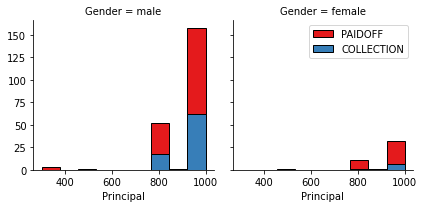

In [160]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

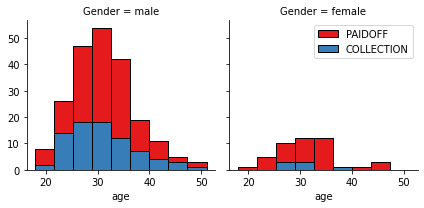

In [161]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

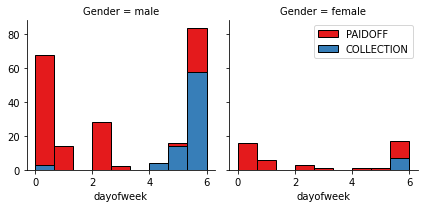

In [162]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [163]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Lets look at gender:

In [164]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [165]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [166]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [167]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [168]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [169]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [170]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [171]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
y = df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values


In [172]:
X_train, y_train= X , y #for easy readability
trainScores={}

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy. 

In [173]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, y_train, test_size=0.3,shuffle = True, random_state = 10)


In [174]:
k = 3
neigh = KNeighborsClassifier(n_neighbors = k).fit(X1_train,y1_train)
yhat = neigh.predict(X1_test)


In [175]:
neigh.fit(X1_train,y1_train)
y_pred=neigh.predict(X1_train)

In [176]:
trainScores['KNN-jaccard']=jaccard_similarity_score(y1_train, y_pred)
trainScores['KNN-f1-score']=f1_score(y1_train, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [177]:
trainScores


{'KNN-f1-score': 0.8104637661361929, 'KNN-jaccard': 0.8140495867768595}

In [178]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X1_train,y1_train)
    yhat=neigh.predict(X1_test)
    mean_acc[n-1] = metrics.accuracy_score(y1_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y1_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.70192308, 0.76923077, 0.81730769, 0.79807692, 0.77884615,
       0.79807692, 0.75961538, 0.79807692, 0.76923077])

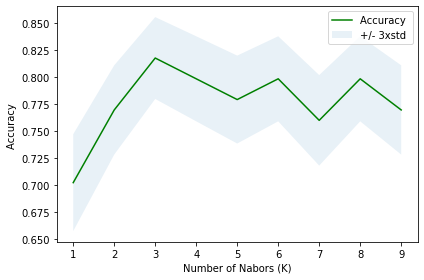

In [179]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [180]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.8173076923076923 with k= 3


# Decision Tree

In [222]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, y_train)
y_pred=clf_tree.predict(X_train)

In [223]:
trainScores['Tree-jaccard']=jaccard_similarity_score(y_train, y_pred)
trainScores['Tree-f1-score']=f1_score(y_train, y_pred, average='weighted')


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [224]:
trainScores

{'KNN-f1-score': 0.8104637661361929,
 'KNN-jaccard': 0.8140495867768595,
 'LogReg-f1-score': 0.6933655063955966,
 'LogReg-jaccard': 0.7543352601156069,
 'LogReg-logLoss': 0.43344699042538454,
 'SVM-f1-score': 0.6441316913797436,
 'SVM-jaccard': 0.7398843930635838,
 'Tree-f1-score': 0.8870748695908691,
 'Tree-jaccard': 0.8930635838150289}

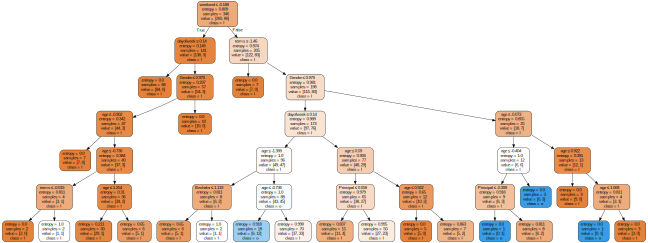

In [189]:
!pip install graphviz
!pip install pydotplus
import graphviz
import pydotplus

dot_data = tree.export_graphviz(clf_tree, out_file=None, 
                     feature_names=['Principal',
                                    'terms','age',
                                    'Gender',
                                    'weekend',
                                    'Bechalor',
                                    'college',
                                    'dayofweek',
                                   ],  
                     class_names='loan_status',  
                     filled=True, rounded=True,  
                     special_characters=True) 

graph = pydotplus.graph_from_dot_data(dot_data)
graph.set_size('"9,9!"')
gvz_graph = graphviz.Source(graph.to_string())

gvz_graph

# Support Vector Machine

In [190]:
y_train=y_train.astype(float)

In [191]:
from sklearn import svm

clf_svm = svm.LinearSVC()
clf_svm.fit(X_train, y_train)  

y_pred=clf_svm.predict(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [192]:
trainScores['SVM-jaccard']=jaccard_similarity_score(y_train, y_pred)
trainScores['SVM-f1-score']=f1_score(y_train, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [193]:
trainScores

{'KNN-f1-score': 0.8104637661361929,
 'KNN-jaccard': 0.8140495867768595,
 'SVM-f1-score': 0.6441316913797436,
 'SVM-jaccard': 0.7398843930635838,
 'Tree-f1-score': 0.7323063690240286,
 'Tree-jaccard': 0.7832369942196532}

# Logistic Regression

In [194]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression()
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)

In [195]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score

In [196]:
trainScores['LogReg-jaccard']=jaccard_similarity_score(y_train, y_pred)
trainScores['LogReg-f1-score']=f1_score(y_train, y_pred, average='weighted')  
trainScores['LogReg-logLoss']=log_loss(y_train, y_proba)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [197]:
trainScores

{'KNN-f1-score': 0.8104637661361929,
 'KNN-jaccard': 0.8140495867768595,
 'LogReg-f1-score': 0.6933655063955966,
 'LogReg-jaccard': 0.7543352601156069,
 'LogReg-logLoss': 0.43344699042538454,
 'SVM-f1-score': 0.6441316913797436,
 'SVM-jaccard': 0.7398843930635838,
 'Tree-f1-score': 0.7323063690240286,
 'Tree-jaccard': 0.7832369942196532}

# Model Evaluation using Test set

First, download and load the test set:

In [198]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-23 05:44:20--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-07-23 05:44:21 (574 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [199]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [200]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#test_df['education'].replace(to_replace=["Bechalor","High School or Below","college","Master or Above"], value=[0,1,2,3],inplace=True)




In [201]:
Feature = test_df[['Principal','terms','age','Gender','weekend','dayofweek']]
Feature = pd.concat([Feature,pd.get_dummies(test_df['education'])], axis=1)
Feature.drop(['Master or Above',"dayofweek"], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [202]:
target = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values
X2 = Feature

y2 = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values

testy=y2.astype(float)
testX= preprocessing.StandardScaler().fit_transform(X2)
testScores={}

In [203]:
#target = test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1]).values#test_df[["loan_status"]].values
#testy= target.astype(float)
#testX= preprocessing.StandardScaler().fit_transform(X)
#testX[:1]

In [225]:
knn_pred = neigh.predict(testX)
testScores['KNN-jaccard']=jaccard_similarity_score(testy, knn_pred)
testScores['KNN-f1-score']=f1_score(testy, knn_pred, average='weighted')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(testy,knn_pred ))

Train set Accuracy:  0.7890173410404624
Test set Accuracy:  0.7222222222222222


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [218]:
tree_pred=clf_tree.predict(testX)
testScores['Tree-jaccard']=jaccard_similarity_score(testy, tree_pred)
testScores['Tree-f1-score']=f1_score(testy, tree_pred, average='weighted')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_tree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(testy,tree_pred ))

Train set Accuracy:  0.8930635838150289
Test set Accuracy:  0.7222222222222222


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [219]:
svm_pred=clf_svm.predict(testX)
testScores['SVM-jaccard']=jaccard_similarity_score(testy, svm_pred)
testScores['SVM-f1-score']=f1_score(testy, svm_pred, average='weighted')
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_svm.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(testy,svm_pred ))

Train set Accuracy:  0.7398843930635838
Test set Accuracy:  0.7407407407407407


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [220]:
log_pred=clf_log.predict(testX)
proba=clf_log.predict_proba(testX)
testScores['LogReg-jaccard']=jaccard_similarity_score(testy, log_pred)
testScores['LogReg-f1-score']=f1_score(testy, log_pred, average='weighted')  
testScores['LogReg-logLoss']=log_loss(testy, proba)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf_log.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(testy,log_pred ))

Train set Accuracy:  0.7543352601156069
Test set Accuracy:  0.7592592592592593


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [221]:
testScores

{'KNN-f1-score': 0.7001989201477693,
 'KNN-jaccard': 0.7222222222222222,
 'LogReg-f1-score': 0.6717642373556352,
 'LogReg-jaccard': 0.7592592592592593,
 'LogReg-logLoss': 0.4808081643472631,
 'SVM-f1-score': 0.6304176516942475,
 'SVM-jaccard': 0.7407407407407407,
 'Tree-f1-score': 0.7105756358768406,
 'Tree-jaccard': 0.7222222222222222}

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | F1-score | Jaccard  | LogLoss |
|--------------------|--------- |----------|---------|
| KNN                | 0.7001   |  0.7222  | NA      |
| Decision Tree      | 0.7105   |  0.8870  | NA      |
| SVM                | 0.6304   |  0.7222  | NA      |
| LogisticRegression | 0.6717   |  0.7592  | 0.4808  |

We can conclude from the table that Decision Tree works best on this dataset.

# Thank you for following along #